In [16]:
import numpy as np
import glob, os, sys
import xarray as xr
import pandas as pd
from scipy.ndimage import label, binary_dilation, binary_erosion, generate_binary_structure
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# For non-gui matplotlib back end
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
mpl.use('agg')

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [29]:
def label_perimeter(tracknumber):
    """
    Labels the perimeter on a 2D map from cell tracknumbers.
    """
    
    # Generate a cross structure
    dilationstructure = generate_binary_structure(2,1)
    
    # Get unique tracknumbers that is no nan
    tracknumber_unique = np.unique(tracknumber[~np.isnan(tracknumber)]).astype(np.int32)

    # Make an array to store the perimeter
    tracknumber_perim = np.zeros(tracknumber.shape, dtype=np.int32)
    
    # Loop over each tracknumbers
    for ii in tracknumber_unique:
        # Isolate the cell mask
        itn = tracknumber == ii
        # Erode the cell by 1 pixel
        itn_erode = binary_erosion(itn, structure=dilationstructure).astype(itn.dtype)
        # Subtract the eroded area to get the perimeter
        iperim = np.logical_xor(itn, itn_erode)
        # Label the perimeter pixels with the cell number
        tracknumber_perim[iperim == 1] = ii
    
    return tracknumber_perim

def calc_cell_center(tracknumber, longitude, latitude, xx, yy):
    """
    Calculates the center location from labeled cells.
    """
    
    # Find unique tracknumbers
    tracknumber_uniqe = np.unique(tracknumber[~np.isnan(tracknumber)])
    num_tracknumber = len(tracknumber_uniqe)
    # Make arrays for cell center locations
    lon_c = np.full(num_tracknumber, np.nan, dtype=float)
    lat_c = np.full(num_tracknumber, np.nan, dtype=float)
    xx_c = np.full(num_tracknumber, np.nan, dtype=float)
    yy_c = np.full(num_tracknumber, np.nan, dtype=float)

    # Loop over each tracknumbers to calculate the mean lat/lon & x/y for their center locations
    for ii, itn in enumerate(tracknumber_uniqe):
        iyy, ixx = np.where(tracknumber == itn)
        # lon_c[ii] = np.mean(longitude[iyy, ixx])
        # lat_c[ii] = np.mean(latitude[iyy, ixx])
        lon_c[ii] = np.mean(longitude[tracknumber == itn])
        lat_c[ii] = np.mean(latitude[tracknumber == itn])
        xx_c[ii] = np.mean(xx[ixx])
        yy_c[ii] = np.mean(yy[iyy])
        
    return lon_c, lat_c, xx_c, yy_c, tracknumber_uniqe

def calc_latlon(lon1, lat1, dist, angle):
    """
    Haversine formula to calculate lat/lon locations from distance and angle.
    
    lon1:   longitude in [degree]
    lat1:   latitude in [degree]
    dist:   distance in [km]
    angle:  angle in [degree]
    """

    import math

    # Earth radius
    # R_earth = 6378.39  # at Equator [km]
    R_earth = 6374.2  # at 40 degree latitude [km]
#     R_earth = 6356.91  # at the pole [km]

    # Conver degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    bearing = math.radians(angle)

    lat2 = math.asin(math.sin(lat1) * math.cos(dist/R_earth) +
                     math.cos(lat1) * math.sin(dist/R_earth) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(dist/R_earth) * math.cos(lat1),
                             math.cos(dist/R_earth) - math.sin(lat1) * math.sin(lat2))
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return lon2, lat2

In [32]:
start_datetime = '2019-01-25T17'
end_datetime = '2019-01-26T00'
input_datetimes = pd.date_range(start=start_datetime, end=end_datetime, freq='15min').strftime('%Y%m%d_%H%M')
input_datetimes

Index(['20190125_1700', '20190125_1715', '20190125_1730', '20190125_1745',
       '20190125_1800', '20190125_1815', '20190125_1830', '20190125_1845',
       '20190125_1900', '20190125_1915', '20190125_1930', '20190125_1945',
       '20190125_2000', '20190125_2015', '20190125_2030', '20190125_2045',
       '20190125_2100', '20190125_2115', '20190125_2130', '20190125_2145',
       '20190125_2200', '20190125_2215', '20190125_2230', '20190125_2245',
       '20190125_2300', '20190125_2315', '20190125_2330', '20190125_2345',
       '20190126_0000'],
      dtype='object')

In [28]:
start_datetime = '2019-01-25T17'
end_datetime = '2019-01-25T20'

iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/'

# datadir = os.path.expandvars('$ICLASS') + f'/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/'
datadir = f'{iclassdir}cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/'
# Generate 15min time marks within the start/end datetime
input_datetimes = pd.date_range(start=start_datetime, end=end_datetime, freq='15min').strftime('%Y%m%d_%H%M')
datafiles = []
for tt in range(0, len(input_datetimes)):
    datafiles.extend(sorted(glob.glob(f'{datadir}celltracks_{input_datetimes[tt]}*.nc')))
print(f'Number of files: {len(datafiles)}')

statsdir = f'{iclassdir}cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/stats/'
statsfile = f'{statsdir}stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'

terrain_file = f'{iclassdir}cacti/radar_processing/corgridded_terrain.c0/topo_cacti_csapr2.nc'

figdir = f'/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/track_demo/'

Number of files: 13


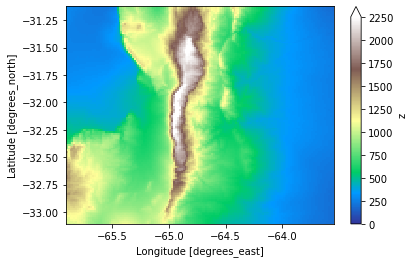

In [5]:
# Read topography file
terr = xr.open_dataset(terrain_file)
topoZ = terr['z']
topoLon = terr['x']
topoLat = terr['y']
topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [6]:
# Read track stats file
dss = xr.open_dataset(statsfile)
dss

<xarray.Dataset>
Dimensions:                  (times: 60, tracks: 6865)
Coordinates:
  * tracks                   (tracks) int32 0 1 2 3 4 ... 6861 6862 6863 6864
  * times                    (times) int32 0 1 2 3 4 5 6 ... 54 55 56 57 58 59
Data variables:
    lifetime                 (tracks) float64 ...
    basetime                 (tracks, times) datetime64[ns] ...
    core_meanlat             (tracks, times) float32 ...
    core_meanlon             (tracks, times) float32 ...
    core_mean_y              (tracks, times) float32 ...
    core_mean_x              (tracks, times) float32 ...
    cell_meanlat             (tracks, times) float32 ...
    cell_meanlon             (tracks, times) float32 ...
    cell_mean_y              (tracks, times) float32 ...
    cell_mean_x              (tracks, times) float32 ...
    cell_minlat              (tracks, times) float32 ...
    cell_minlon              (tracks, times) float32 ...
    cell_maxlat              (tracks, times) float32 ...
    cell_maxlon              (tracks, times) float32 ...
    cell_min_y               (tracks, times) float32 ...
    cell_min_x               (tracks, times) float32 ...
    cell_max_y               (tracks, times) float32 ...
    cell_max_x               (tracks, times) float32 ...
    dilatecell_meanlat       (tracks, times) float32 ...
    dilatecell_meanlon       (tracks, times) float32 ...
    dilatecell_mean_y        (tracks, times) float32 ...
    dilatecell_mean_x        (tracks, times) float32 ...
    core_radius              (tracks, times) float32 ...
    cell_radius              (tracks, times) float32 ...
    core_area                (tracks, times) float32 ...
    cell_area                (tracks, times) float32 ...
    maxdbz                   (tracks, times) float32 ...
    maxETH_10dbz             (tracks, times) float32 ...
    maxETH_20dbz             (tracks, times) float32 ...
    maxETH_30dbz             (tracks, times) float32 ...
    maxETH_40dbz             (tracks, times) float32 ...
    maxETH_50dbz             (tracks, times) float32 ...
    cloudnumber              (tracks, times) float64 ...
    status                   (tracks, times) float64 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_tracknumber  (tracks) float64 ...
    start_split_timeindex    (tracks) float64 ...
    start_split_cloudnumber  (tracks) float64 ...
    end_merge_tracknumber    (tracks) float64 ...
    end_merge_timeindex      (tracks) float64 ...
    end_merge_cloudnumber    (tracks) float64 ...
    merge_tracknumbers       (tracks, times) float64 ...
    split_tracknumbers       (tracks, times) float64 ...
    trackinterruptions       (tracks) float64 ...
    maxrange_flag            (tracks, times) float64 ...
Attributes:
    title:                 File containing statistics for each track
    Institution:           Pacific Northwest National Laboratoy
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Wed Jul  1 05:25:28 2020
    source:                CSAPR2
    description:           COR
    startdate:             20181015.0000
    enddate:               20190303.0000
    track_version:         v1.0
    tracknumbers_version:  v1.0
    timegap_hour:          0.5
    time_resolution_hour:  0.25
    pixel_radius_km:       0.5

In [7]:
# stime = pd.to_datetime(start_datetime)
# etime = pd.to_datetime(end_datetime)
# np.where((stats_starttime >= stime) & (stats_starttime <= etime))[0]

In [8]:
stime = np.datetime64(start_datetime)
etime = np.datetime64(end_datetime)

stats_bt = dss.basetime
stats_starttime = stats_bt.isel(times=0)

# Find track initiated within the time window
idx = np.where((stats_starttime >= stime) & (stats_starttime <= etime))[0]
print(f'Number of tracks within input period: {len(idx)}')

time_res = dss.attrs['time_resolution_hour']
lifetime = dss.lifetime.isel(tracks=idx) * time_res
cell_bt = dss.basetime.isel(tracks=idx)
cell_lon = dss.cell_meanlon.isel(tracks=idx)
cell_lat = dss.cell_meanlat.isel(tracks=idx)
start_split_tracknumber = dss.start_split_tracknumber.isel(tracks=idx)
end_merge_tracknumber = dss.end_merge_tracknumber.isel(tracks=idx)

# Select long-lived tracks
idx_long = np.where(lifetime > 0.5)[0]
ntracks_long = len(idx_long)
print(f'Number of long tracks within input period: {ntracks_long}')

lifetime_long = lifetime.isel(tracks=idx_long)
cell_bt_long = cell_bt.isel(tracks=idx_long)
cell_lon_long = cell_lon.isel(tracks=idx_long)
cell_lat_long = cell_lat.isel(tracks=idx_long)
start_split_tracknumber_long = start_split_tracknumber.isel(tracks=idx_long)
end_merge_tracknumber_long = end_merge_tracknumber.isel(tracks=idx_long)

Number of tracks within input period: 35
Number of long tracks within input period: 13


In [9]:
# minlat, maxlat = np.min(topoLat.values), np.max(topoLat.values)
# minlon, maxlon = np.min(topoLon.values), np.max(topoLon.values)
# print(minlon, maxlon, minlat, maxlat)

In [37]:
itrack = 0
idur = (lifetime.values[itrack] / time_res).astype(int)
ibt = cell_bt.values[itrack,:idur]
ibt_last = np.nanmax(ibt)
# # Find times in track data <= current pixel-level file time
# idx_cut = np.where(ibt <= pixel_bt)[0]
# idur_cut = len(idx_cut)

In [127]:
pixel_bt

array(['2019-01-25T20:00:00.000000000'], dtype='datetime64[ns]')

In [130]:
80*1.25

100.0

In [149]:
markers = np.repeat("o", 3)
markers[0] = "D"
markers

array(['D', 'o', 'o'], dtype='<U1')

In [151]:
markers = ["o"] * 3
markers[0] = "D"
markers

['D', 'o', 'o']

In [176]:
def plot_map(xx, yy, comp_ref, tn_perim, pixel_bt, levels, cmaps, cblabels, cbticks, timestr, dt_thres, 
             ntracks, lifetime, cell_bt, cell_lon, cell_lat, figname):

    mpl.rcParams['font.size'] = 14
    mpl.rcParams['font.family'] = 'Helvetica'

    size_centroid = 80
    lw_centroid = 1.5
    
    radii = np.arange(20,101,20)  # radii for the range rings [km]
    azimuths = np.arange(0,361,30)  # azimuth angles for HSRHI scans [degree]
    radar_lon, radar_lat = -64.7284, -32.1264  # CSAPR radar location

    topo_levs = [500,1000,1500,2000,2500]
    cmap_topo = 'Reds'

    radii = np.arange(20,101,20)  # radii for the range rings [km]
    azimuths = np.arange(0,361,30)  # azimuth angles for HSRHI scans [degree]
    radar_lon, radar_lat = -64.7284, -32.1264  # CSAPR radar location

    map_extend = [np.min(xx), np.max(xx), np.min(yy), np.max(yy)]
    # map_extend = [minlon, maxlon, minlat, maxlat]
    lonvals = mpl.ticker.FixedLocator(np.arange(-66,-63,0.5))
    latvals = mpl.ticker.FixedLocator(np.arange(-34,-30,0.5))
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=[8,7.5], dpi=200)
    gs = gridspec.GridSpec(1,2, height_ratios=[1], width_ratios=[1,0.03])
    gs.update(wspace=0.05, hspace=0.05)

    # ax1 = plt.subplot(111, projection=proj)
    ax1 = plt.subplot(gs[0], projection=proj)
    ax1.set_extent(map_extend, crs=proj)
    ax1.set_aspect('auto', adjustable=None)
    gl = ax1.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0, zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = lonvals
    gl.ylocator = latvals
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1, transform=proj)

    # Plot reflectivity
    cmap = plt.get_cmap(cmaps)
    norm_ref = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    cf1 = ax1.pcolormesh(xx, yy, comp_ref, norm=norm_ref, cmap=cmap, transform=proj, zorder=2)
    # Overplot cell tracknumber perimeters
    Tn = np.ma.masked_where(tn_perim == 0, tn_perim)
    Tn[Tn > 0] = 10
    tn1 = ax1.pcolormesh(xx, yy, Tn, cmap='gray', transform=proj, zorder=3)

    # Plot track centroids and paths
    marker_style = dict(edgecolor='k', linestyle='-', marker='o')
    for itrack in range(0, ntracks):
    # for itrack in range(9, 10):
        idur = (lifetime.values[itrack] / time_res).astype(int)
        ibt = cell_bt.values[itrack,:idur]
        # Get the last time of the track
        ibt_last = np.nanmax(ibt)
        # Compute time difference between current pixel-level data time and the last time of the track
        idt = (pixel_bt - ibt_last).astype('timedelta64[m]')
        # Proceed if time difference is <= threshold
        # This means for tracks that end longer than the time threshold will not be plotted
        if (idt <= dt_thres):
            # Find times in track data <= current pixel-level file time
            idx_cut = np.where(ibt <= pixel_bt)[0]
            idur_cut = len(idx_cut)
            if (idur_cut > 0):
                color_vals = np.repeat(lifetime.values[itrack], idur_cut)
                size_vals = np.repeat(size_centroid, idur_cut)
                size_vals[0] = size_centroid*1.75
                cc = ax1.plot(cell_lon.values[itrack,idx_cut], cell_lat.values[itrack,idx_cut], lw=lw_centroid, ls='-', color='k', transform=proj, zorder=3)
                cl = ax1.scatter(cell_lon.values[itrack,idx_cut], cell_lat.values[itrack,idx_cut], s=size_vals, c=color_vals, 
                                 vmin=0.5, vmax=5, cmap='Spectral_r', transform=proj, zorder=4, **marker_style)

    # Plot range circles around radar
    for ii in range(0, len(radii)):
        rr = ax1.tissot(rad_km=radii[ii], lons=radar_lon, lats=radar_lat, n_samples=100, facecolor='None', edgecolor='k', lw=0.4, zorder=3)
    # Plot azimuth lines
    for ii in range(0, len(azimuths)):
        lon2, lat2 = calc_latlon(radar_lon, radar_lat, 200, azimuths[ii])
        ax1.plot([radar_lon,lon2], [radar_lat,lat2], color='k', lw=0.4, transform=ccrs.Geodetic(), zorder=5)
    # Reflectivity colorbar
    cax1 = plt.subplot(gs[1])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels, ticks=cbticks, extend='both')
    ax1.set_title(timestr)

#     fig.savefig(figname, dpi=300, bbox_inches='tight')

    # Thread-safe figure output
    canvas = FigureCanvas(fig)
    canvas.print_png(figname)
    fig.savefig(figname)
    
    return fig

In [177]:
def work_for_time_loop(datafile, ntracks, lifetime, cell_bt, cell_lon, cell_lat, dt_thres, figdir):

    # Read pixel-level data
    ds = xr.open_dataset(datafile)
    # Make x,y coordinates
    ds.coords['lon'] = ds.lon - 100
    ds.coords['lat'] = ds.lat - 100
    xx = ds.lon.data
    yy = ds.lat.data
    longitude = ds.longitude.data
    latitude = ds.latitude.data
    pixel_bt = ds.time.data

    # Get cell tracknumbers and cloudnumbers
    tn = ds.tracknumber.squeeze()
    cn = ds.cloudnumber.squeeze()

    # Find cells that are not tracked (tracknumber == nan)
    cn_notrack = cn.where(np.isnan(tn))

    # Get cell perimeters
    tn_perim = label_perimeter(tn.data)
    cn_perim = label_perimeter(cn.data)
    cn_notrack_perim = label_perimeter(cn_notrack.data)
    
    # Apply tracknumber to conv_mask1
    conv = ds.conv_mask.squeeze()
    tnconv1 = tn.where(conv > 0).data

    # Calculates cell center locations
    lon_tn1, lat_tn1, xx_tn1, yy_tn1, tnconv1_uniqe = calc_cell_center(tnconv1, longitude, latitude, xx, yy)
    lon_cn1, lat_cn1, xx_cn1, yy_cn1, cnnotrack_unique = calc_cell_center(cn_notrack.data, longitude, latitude, xx, yy)

    comp_ref = ds.comp_ref.squeeze()
    levels = np.arange(-10, 60.1, 5)
    cbticks = np.arange(-10, 60.1, 5)
    cmaps = 'gist_ncar'
    timestr = ds.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
    # titles = [timestr]
    cblabels = 'Composite Reflectivity (dBZ)'
    fignametimestr = ds.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
    figname = figdir + fignametimestr + '.png'

    fig = plot_map(longitude, latitude, comp_ref, tn_perim, pixel_bt, levels, cmaps, cblabels, cbticks, timestr, dt_thres, 
                   ntracks, lifetime, cell_bt, cell_lon, cell_lat, figname)

    # plt.close(fig)
    ds.close()

In [178]:
datafiles

['/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1700.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1715.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1730.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1745.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1800.nc',
 '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing

/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1700.nc
/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1715.nc
/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1730.nc
/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1745.nc
/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_1800.nc
/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrp

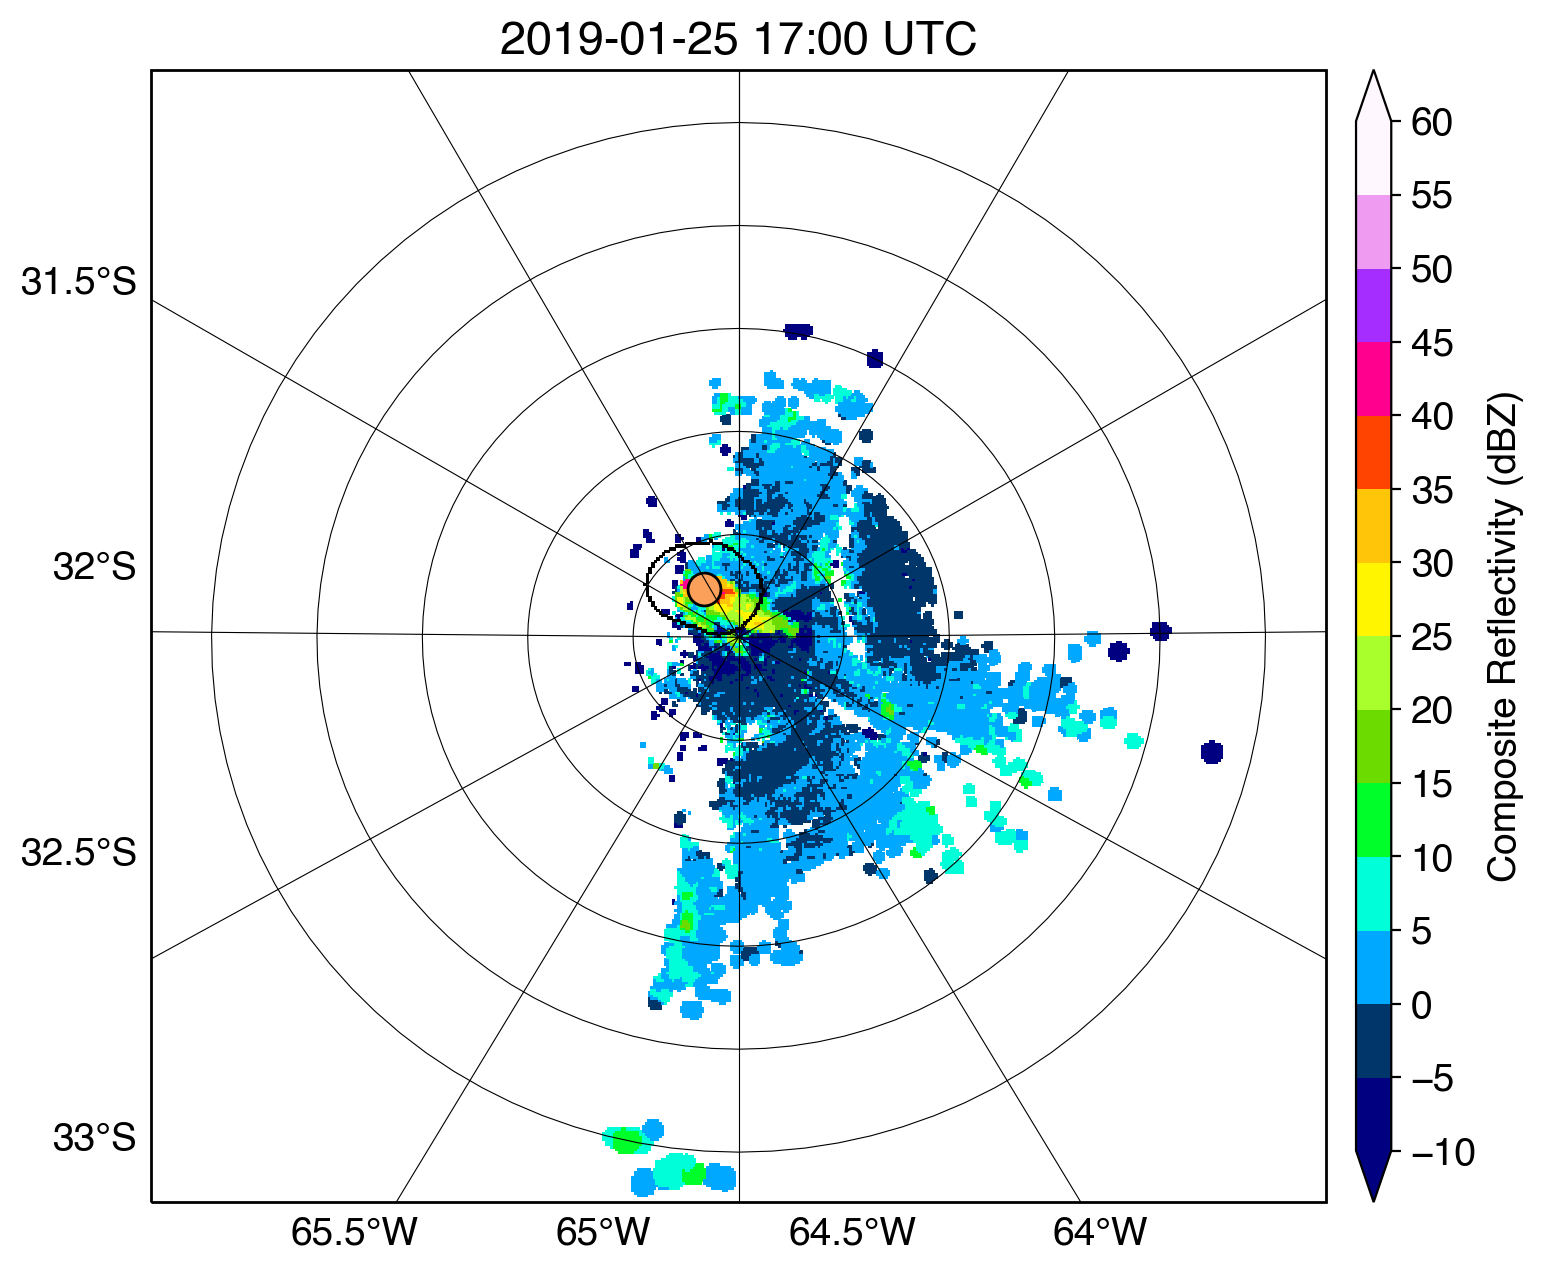

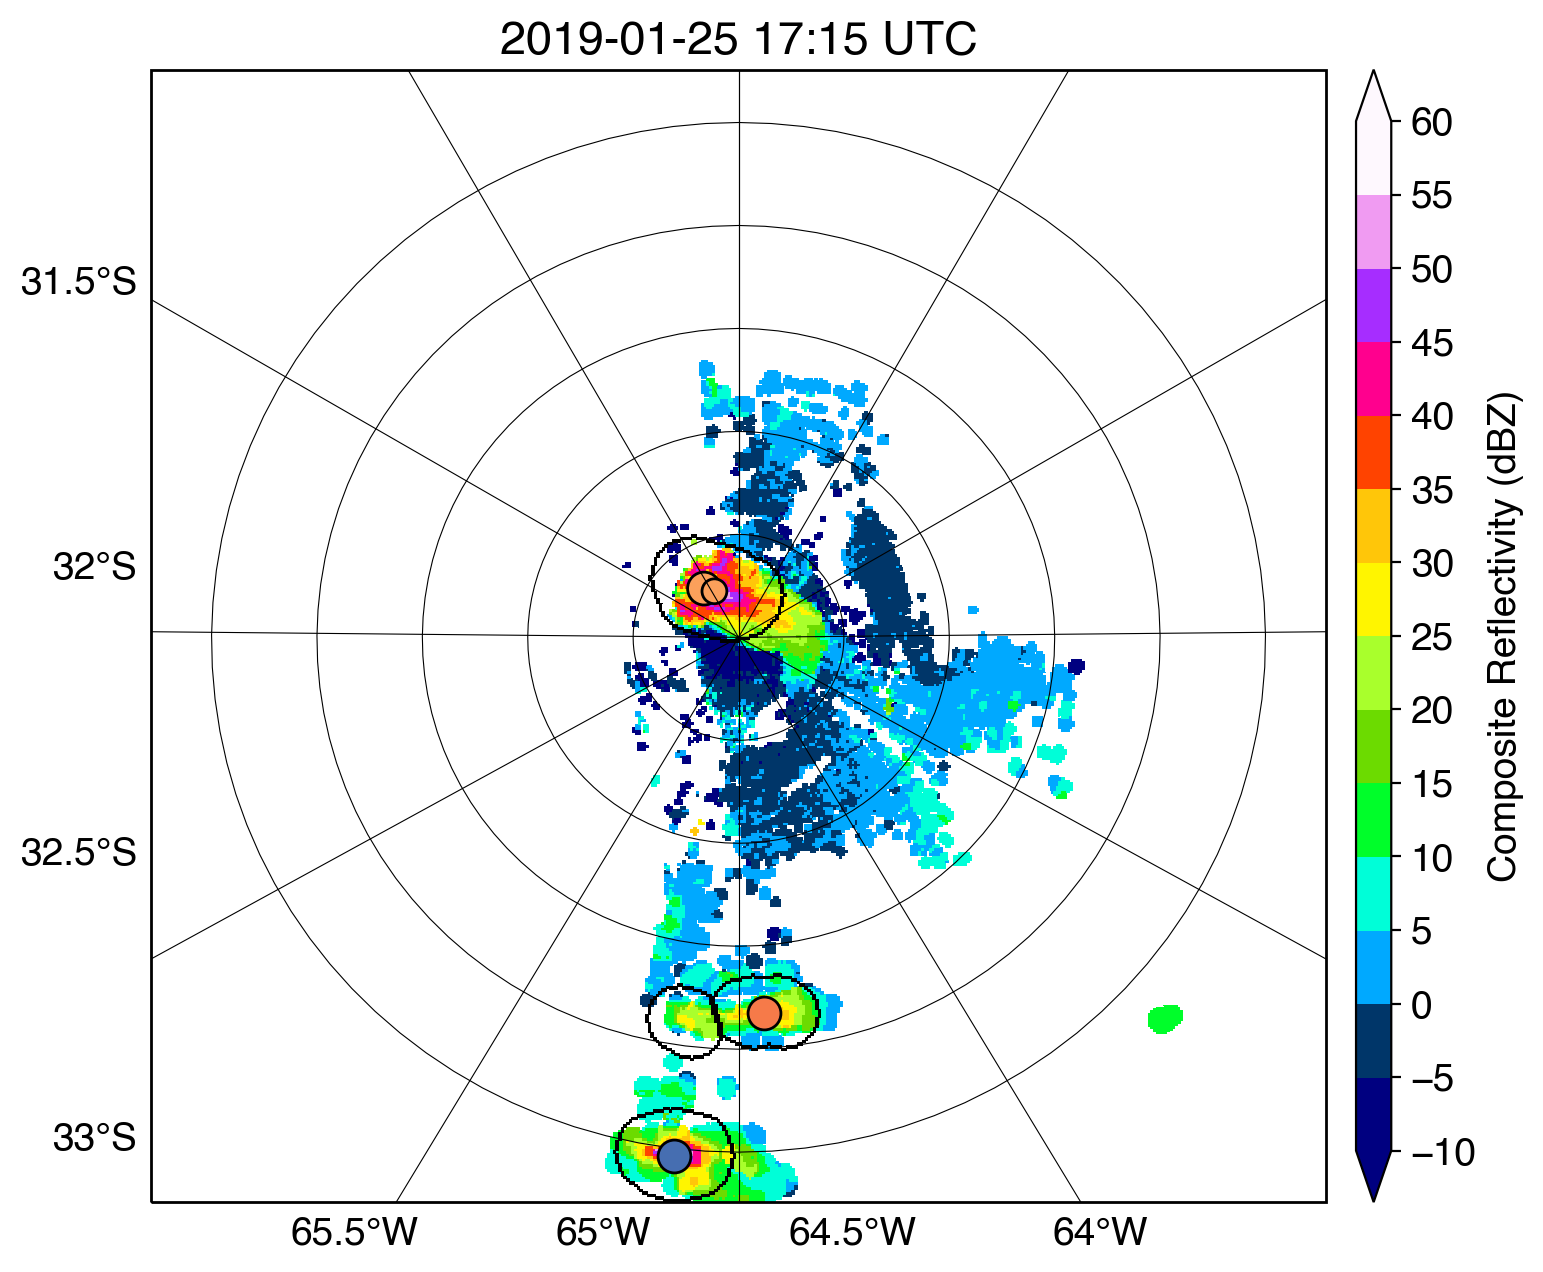

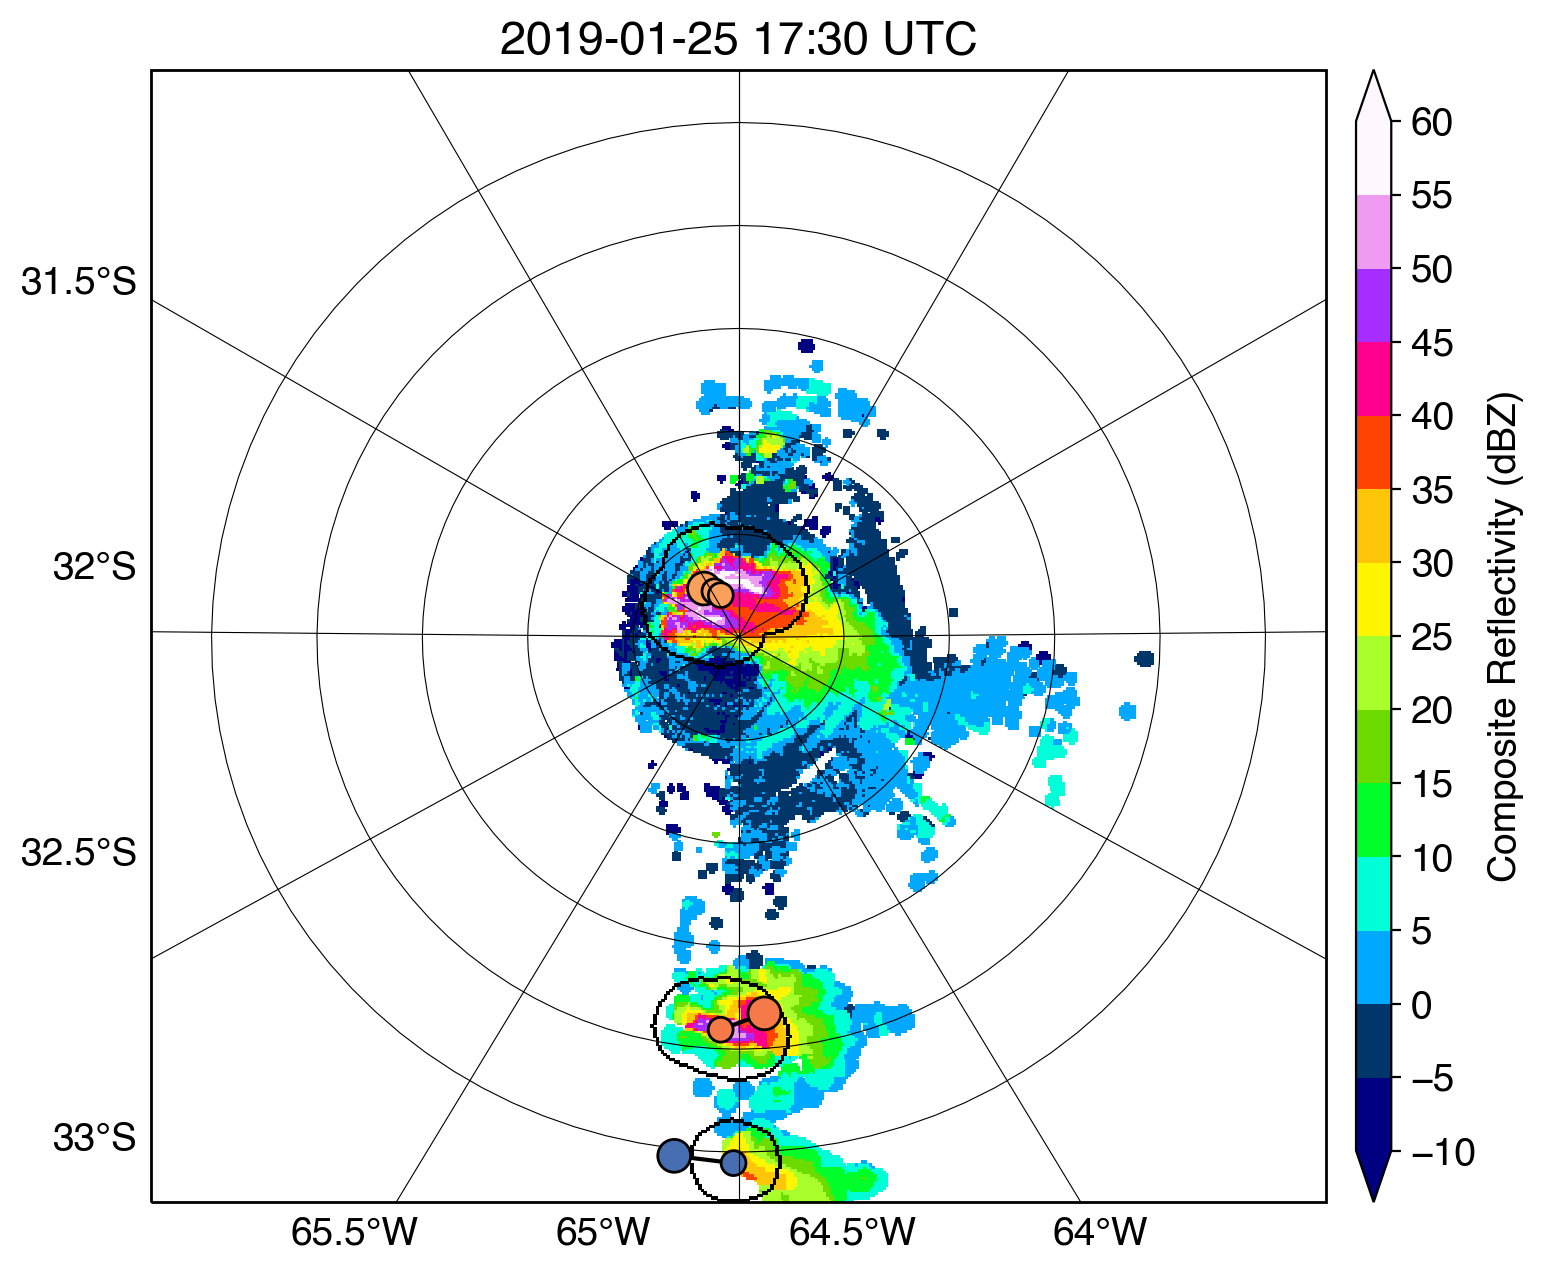

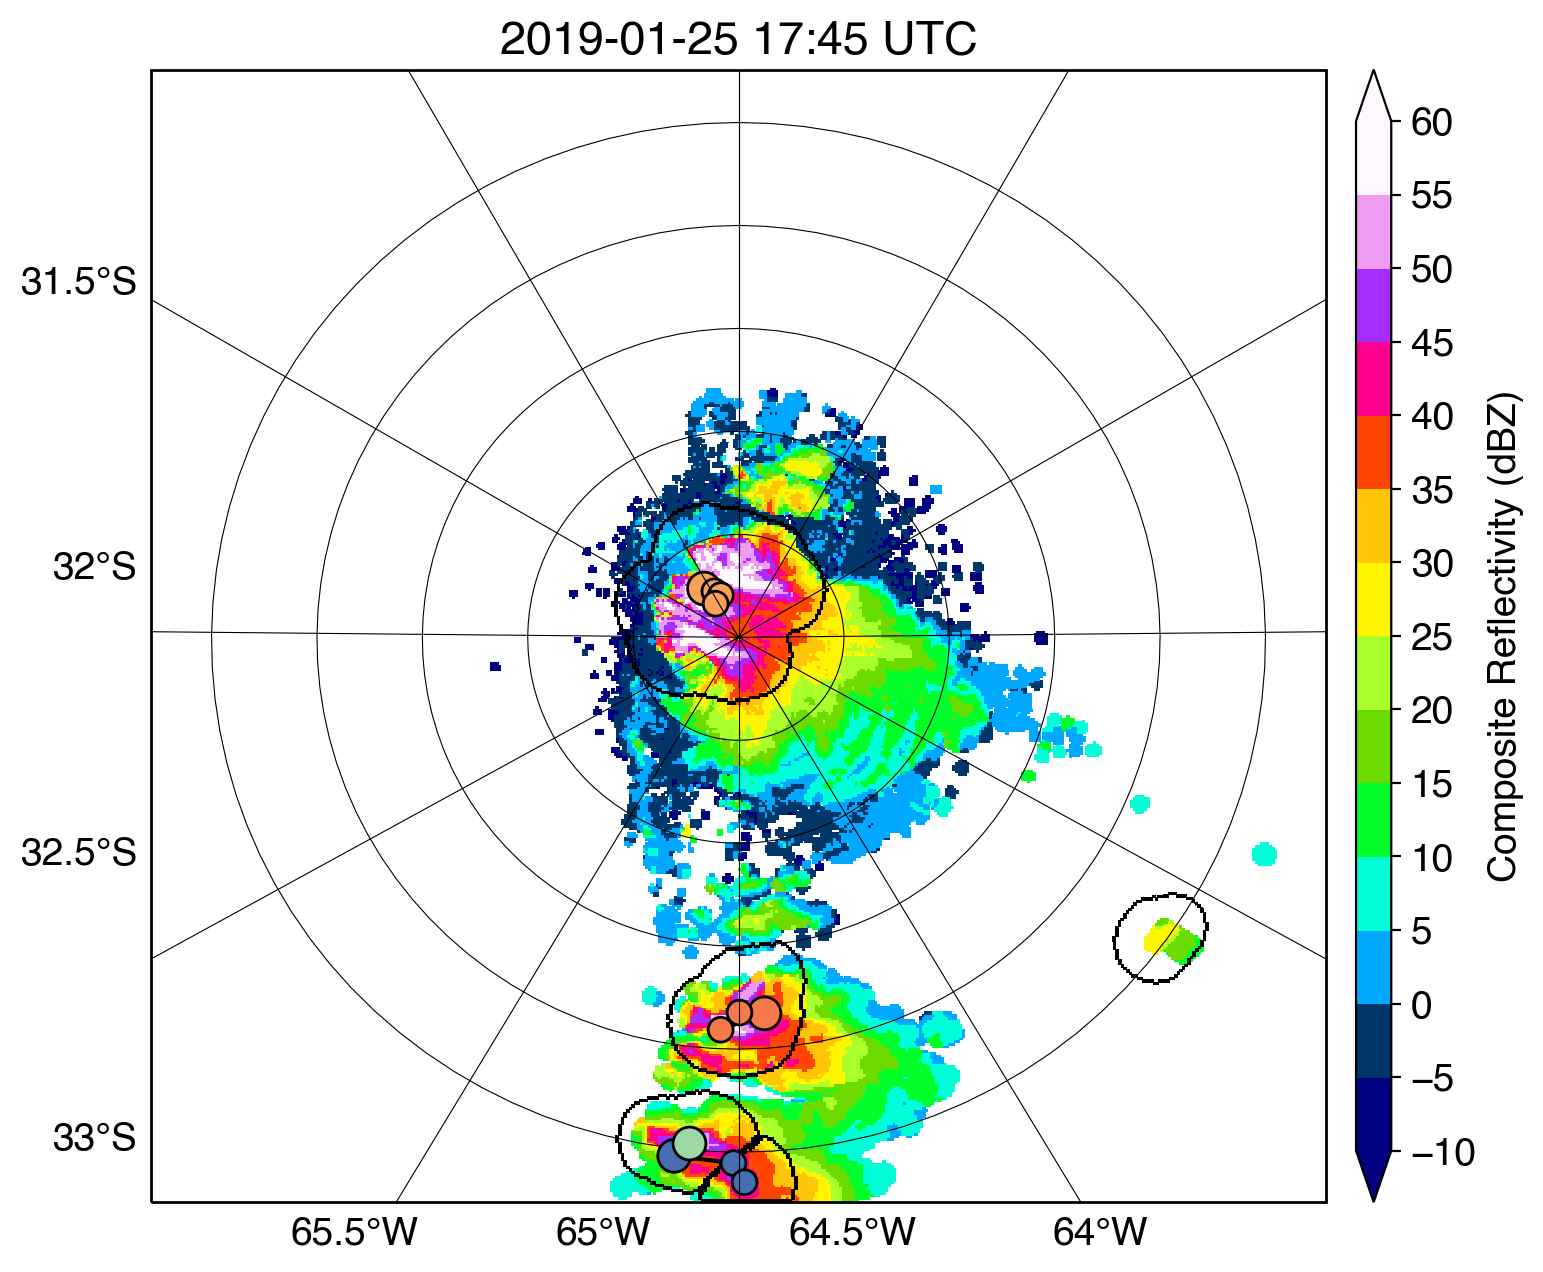

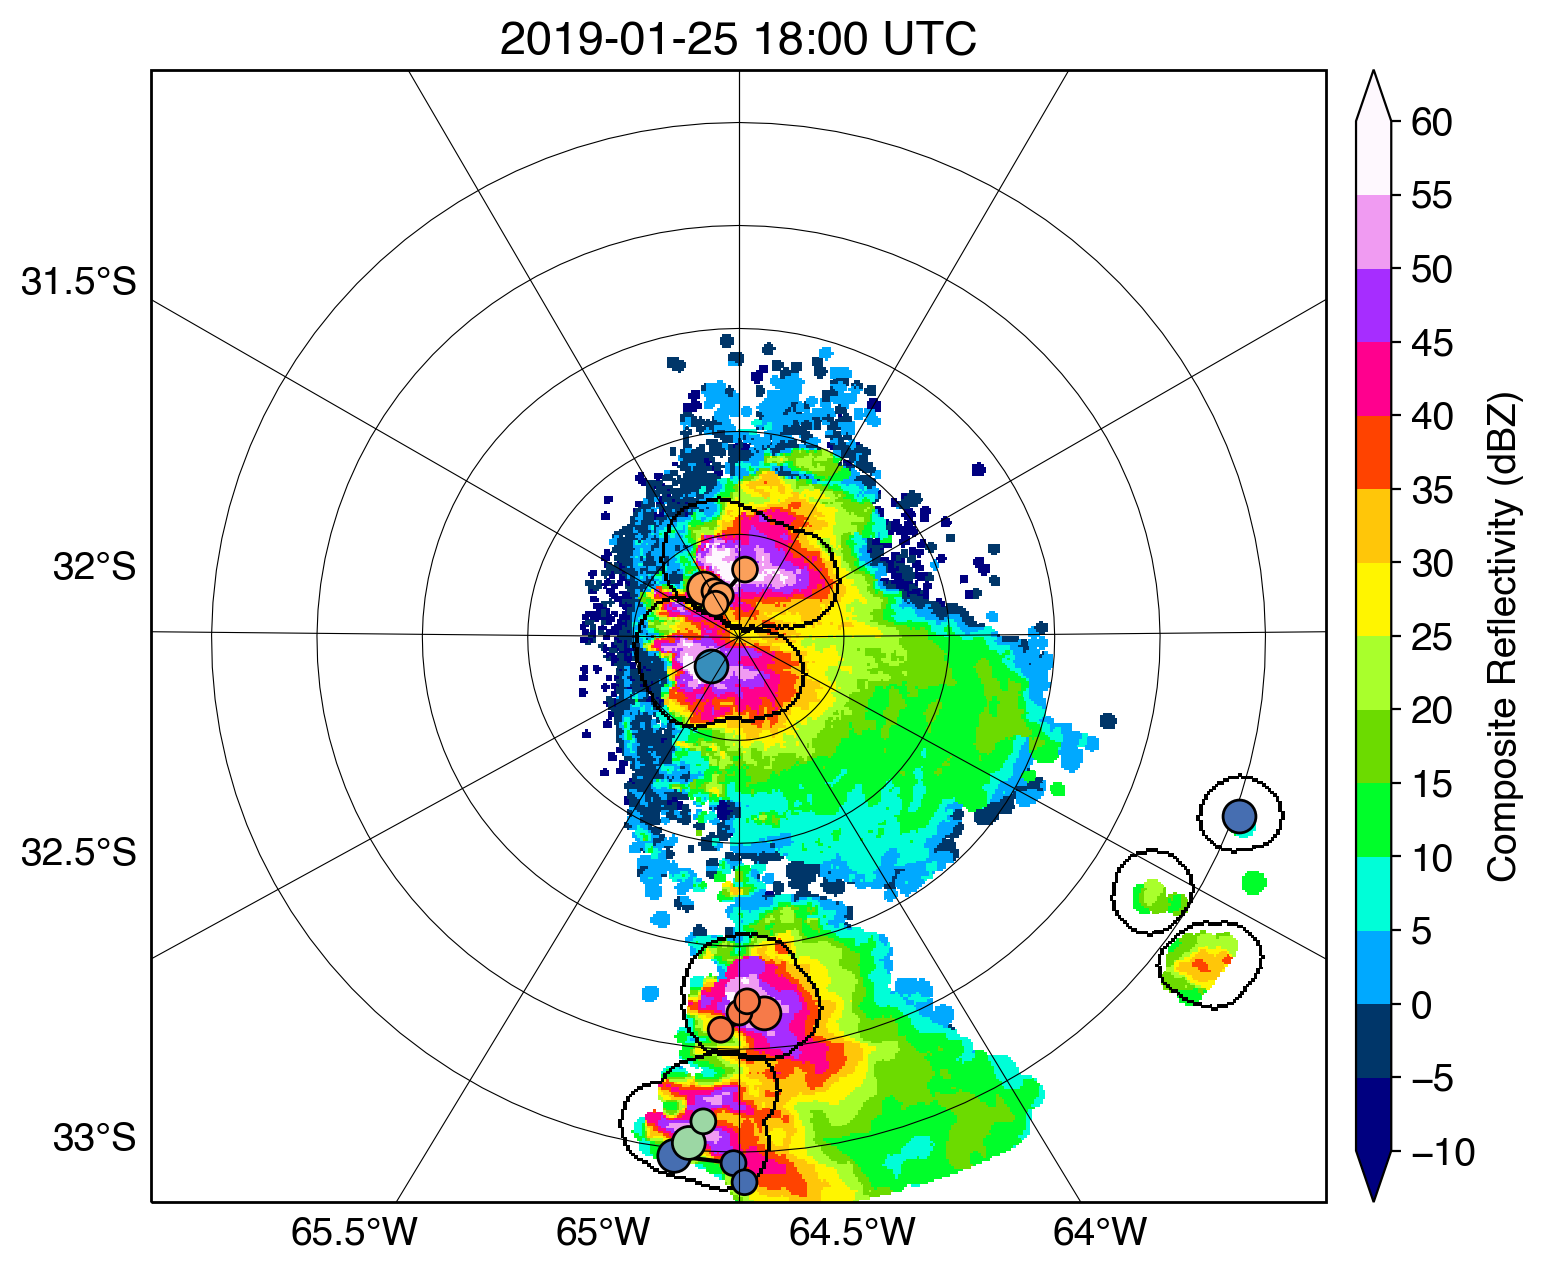

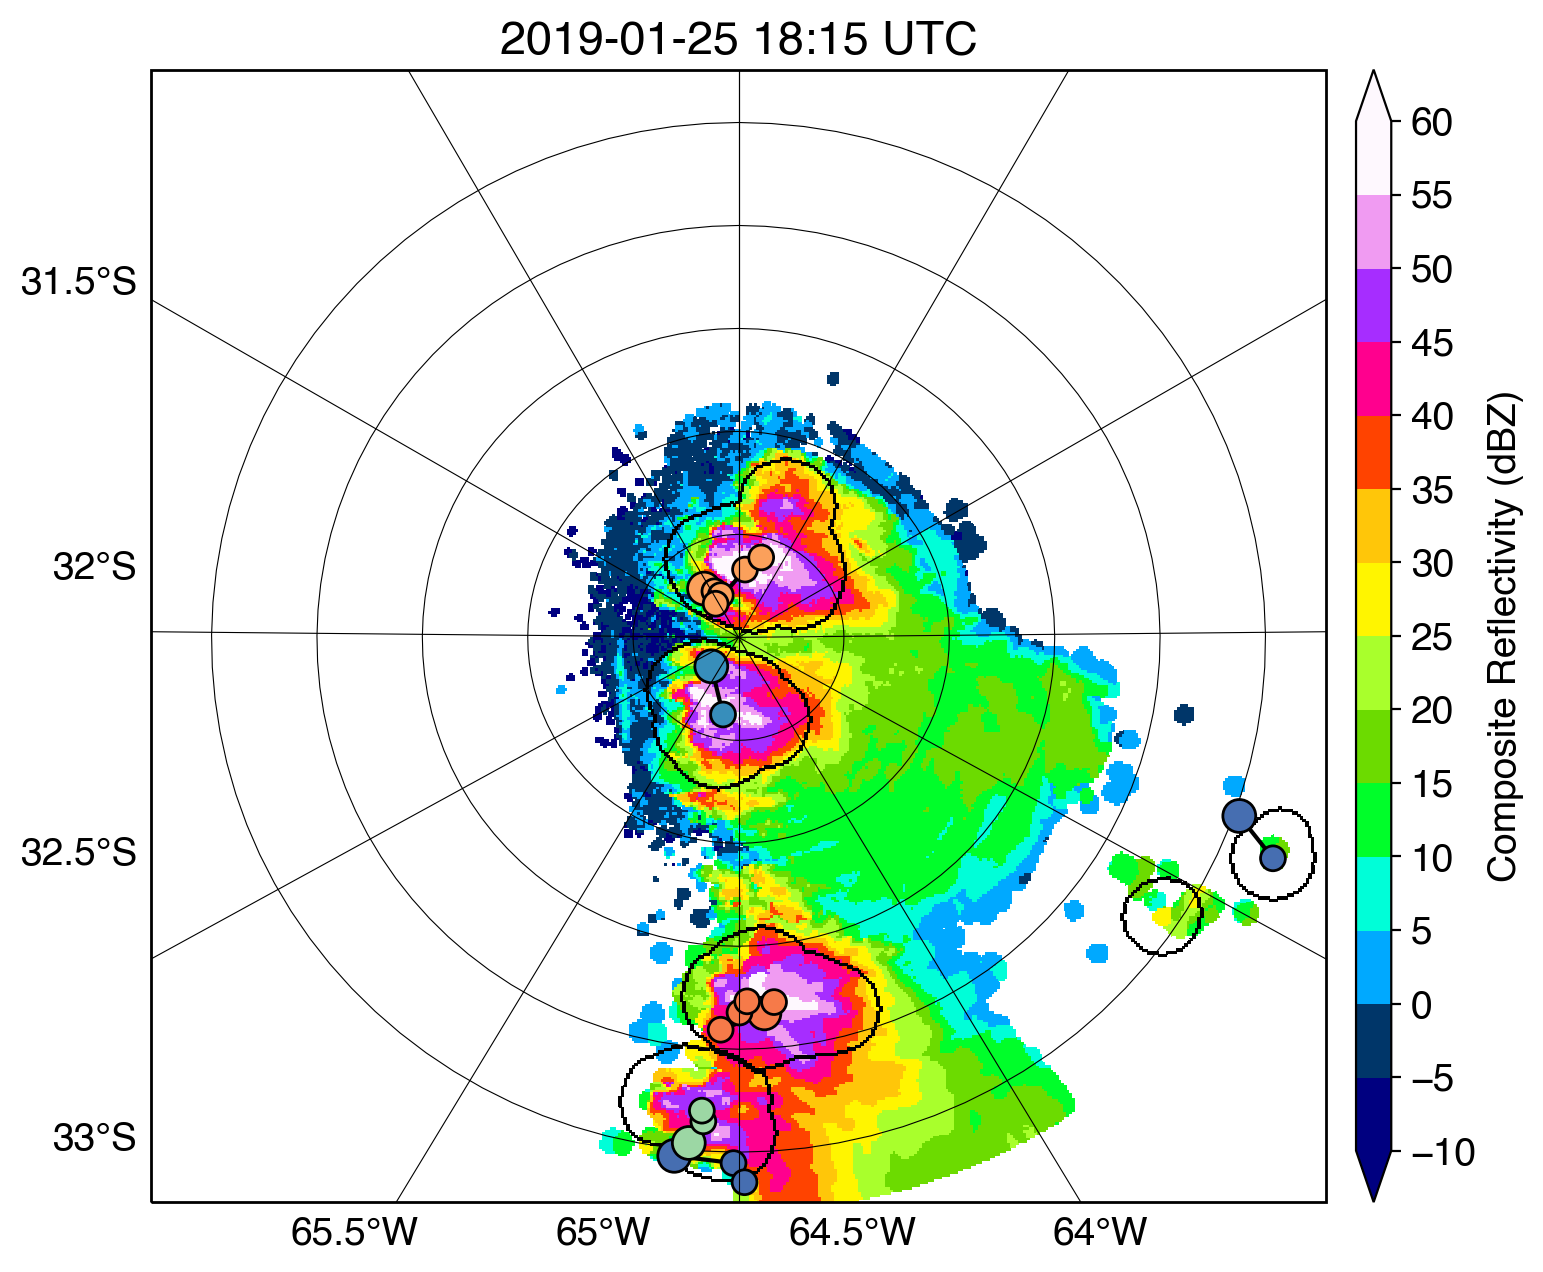

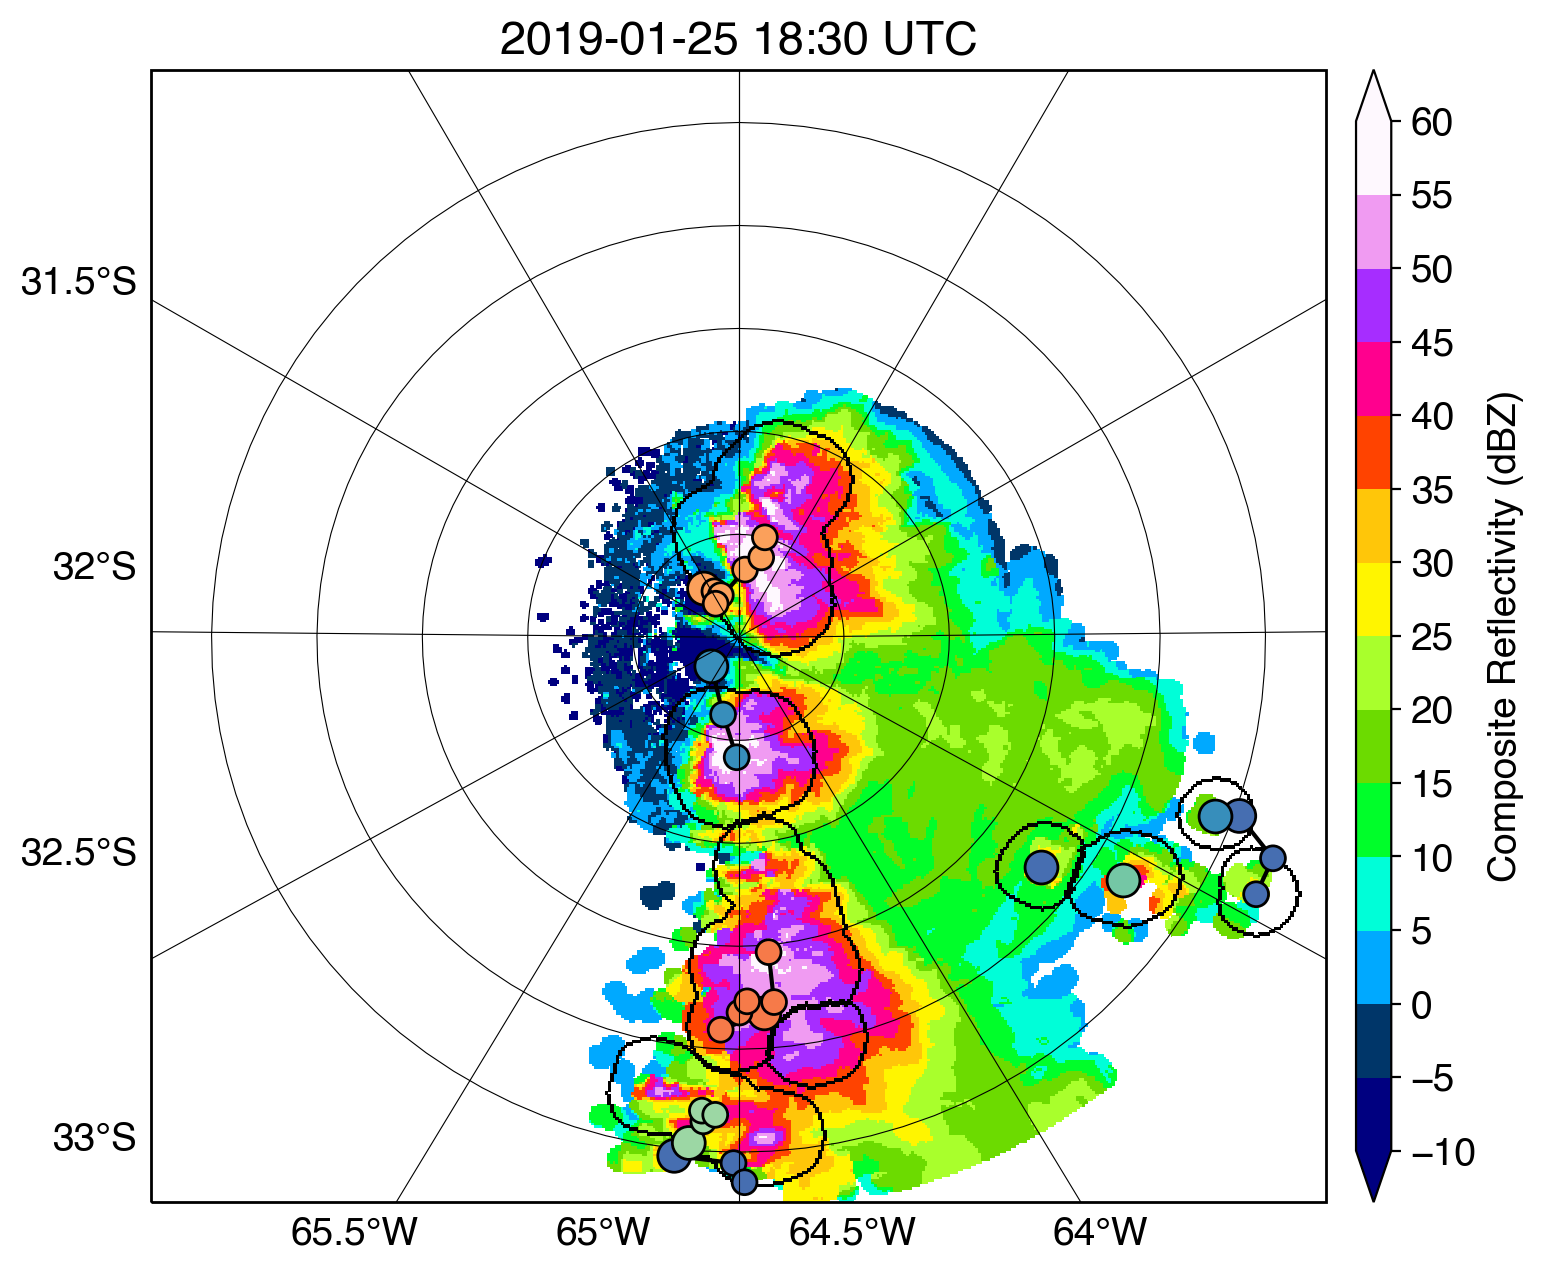

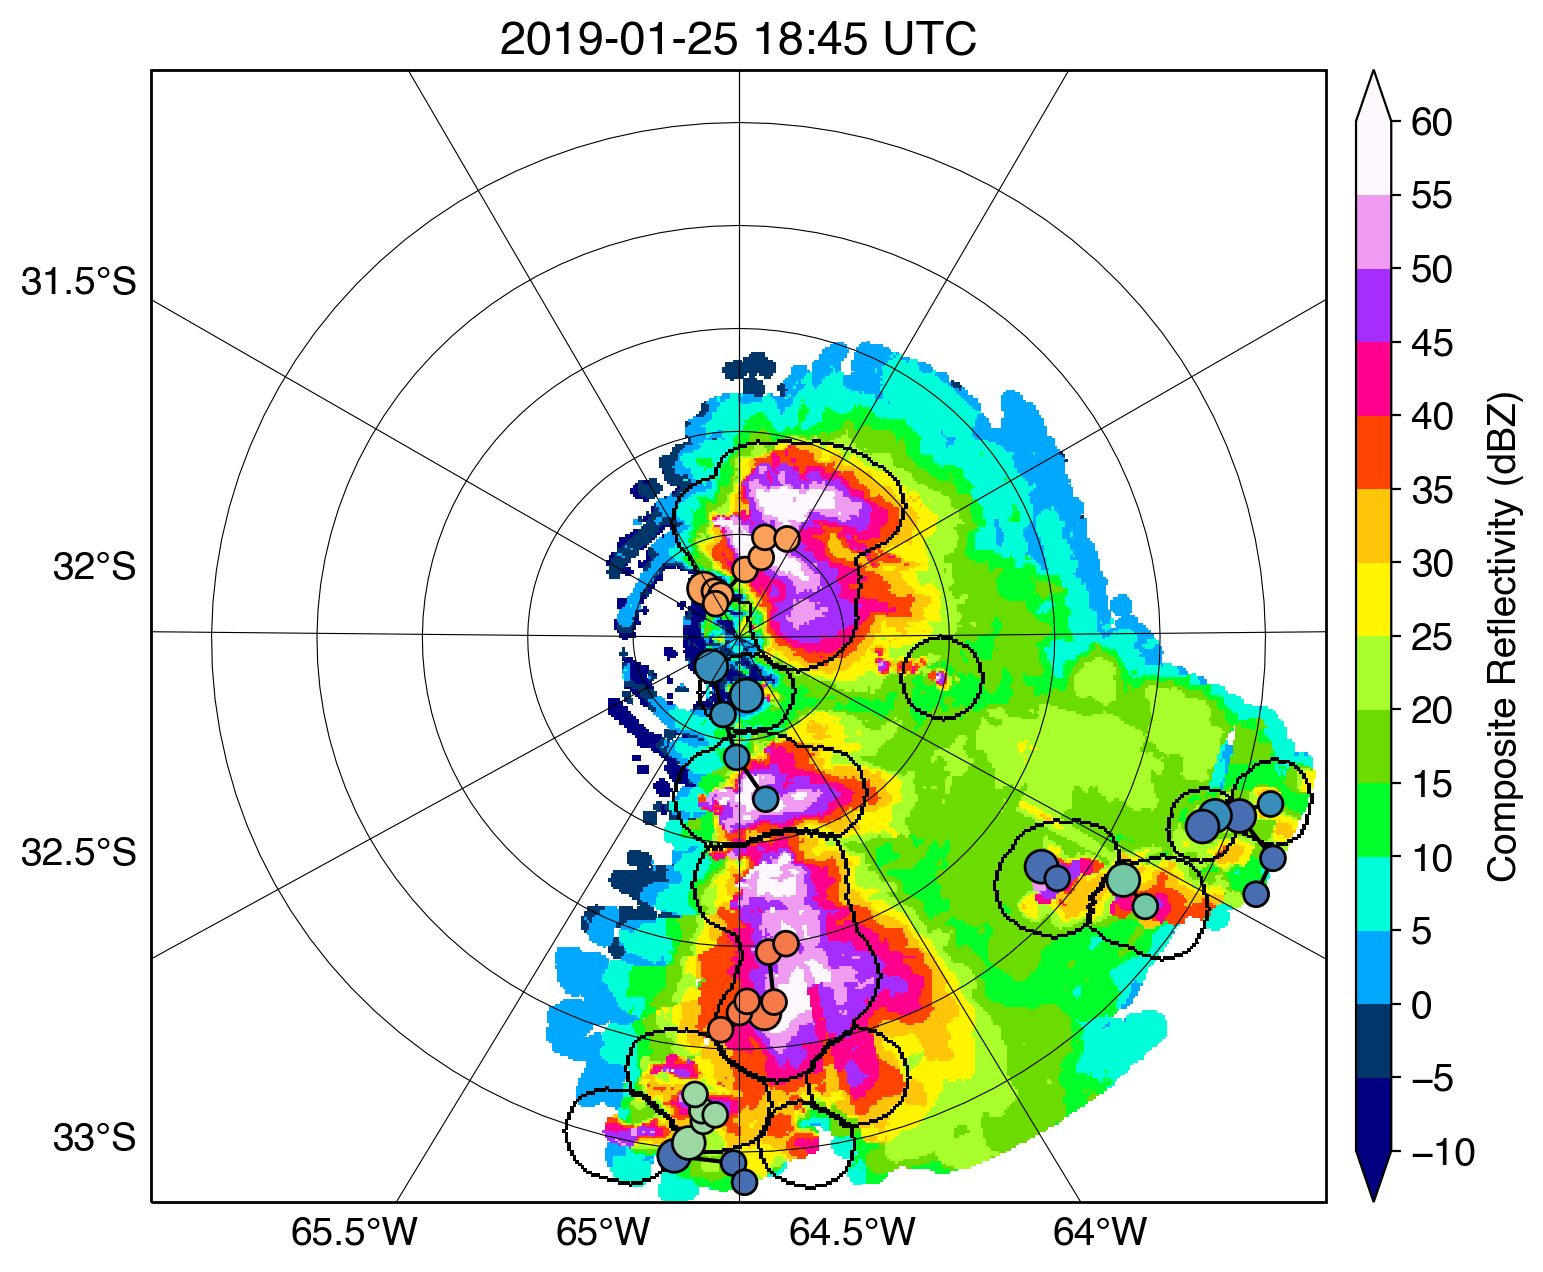

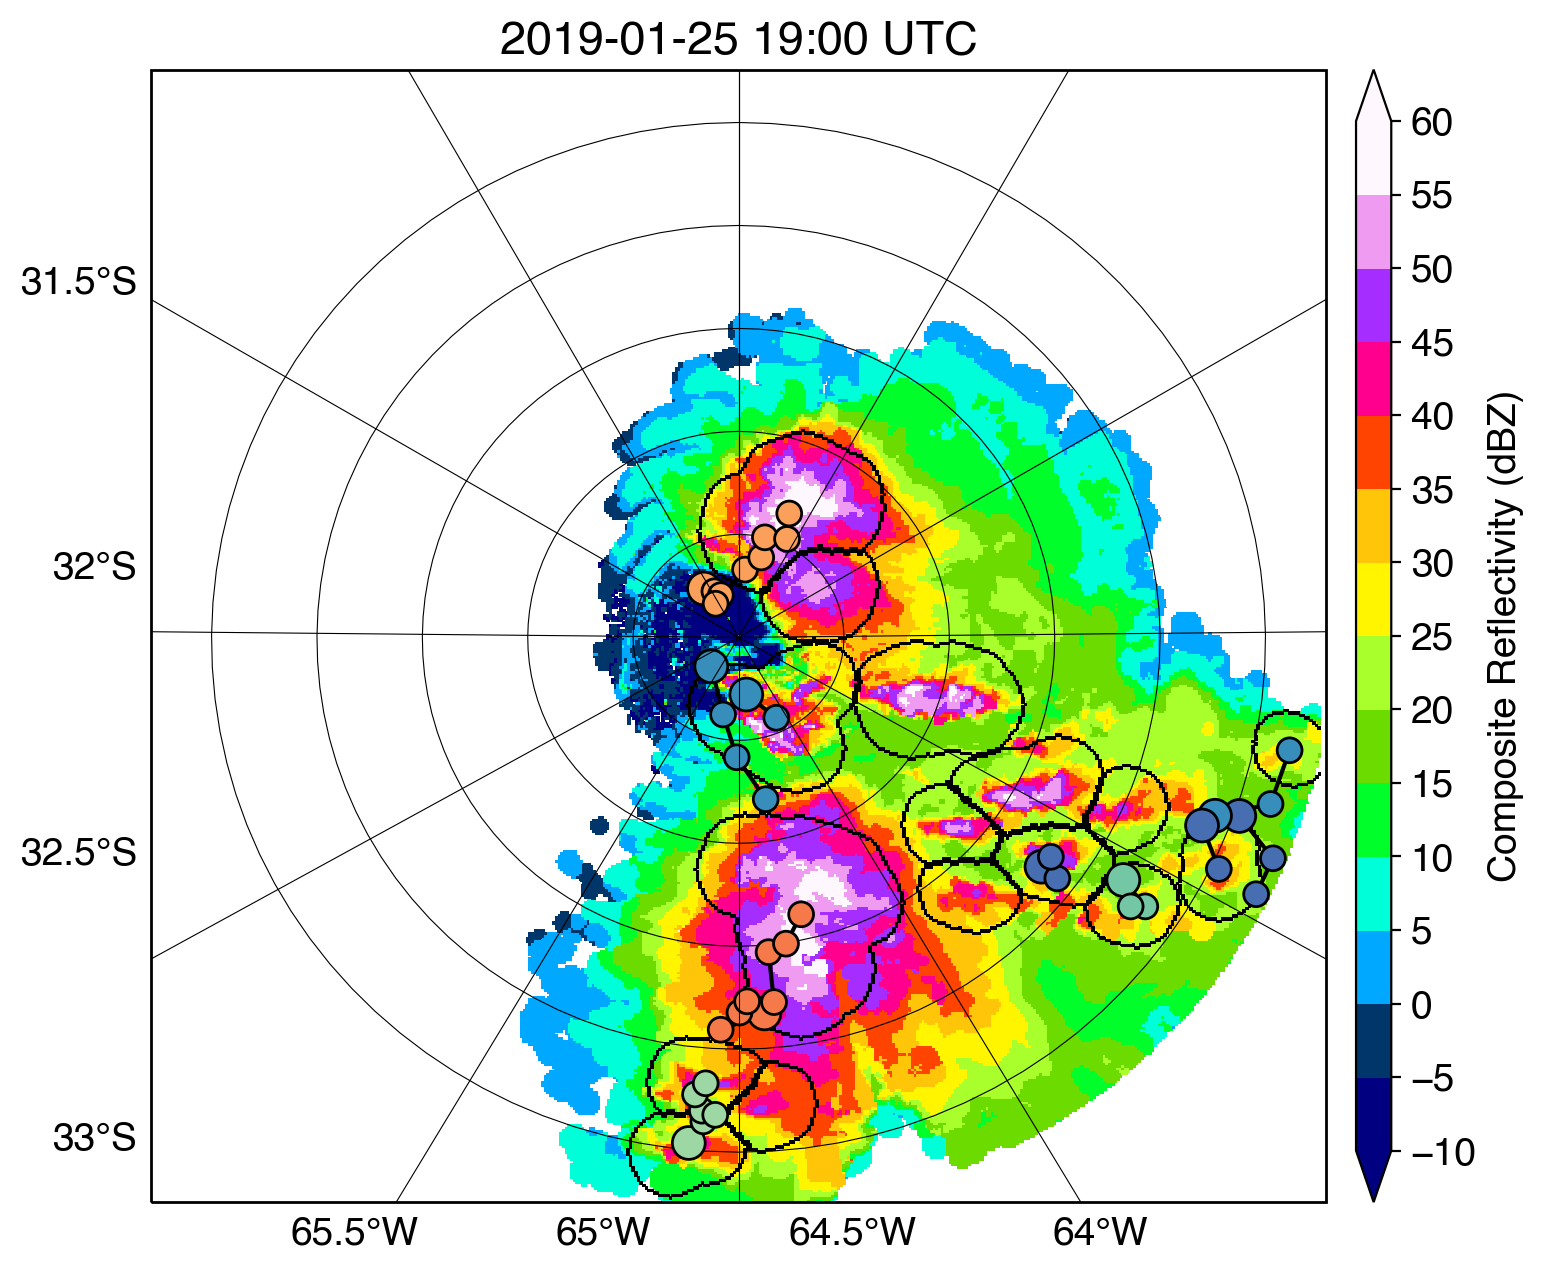

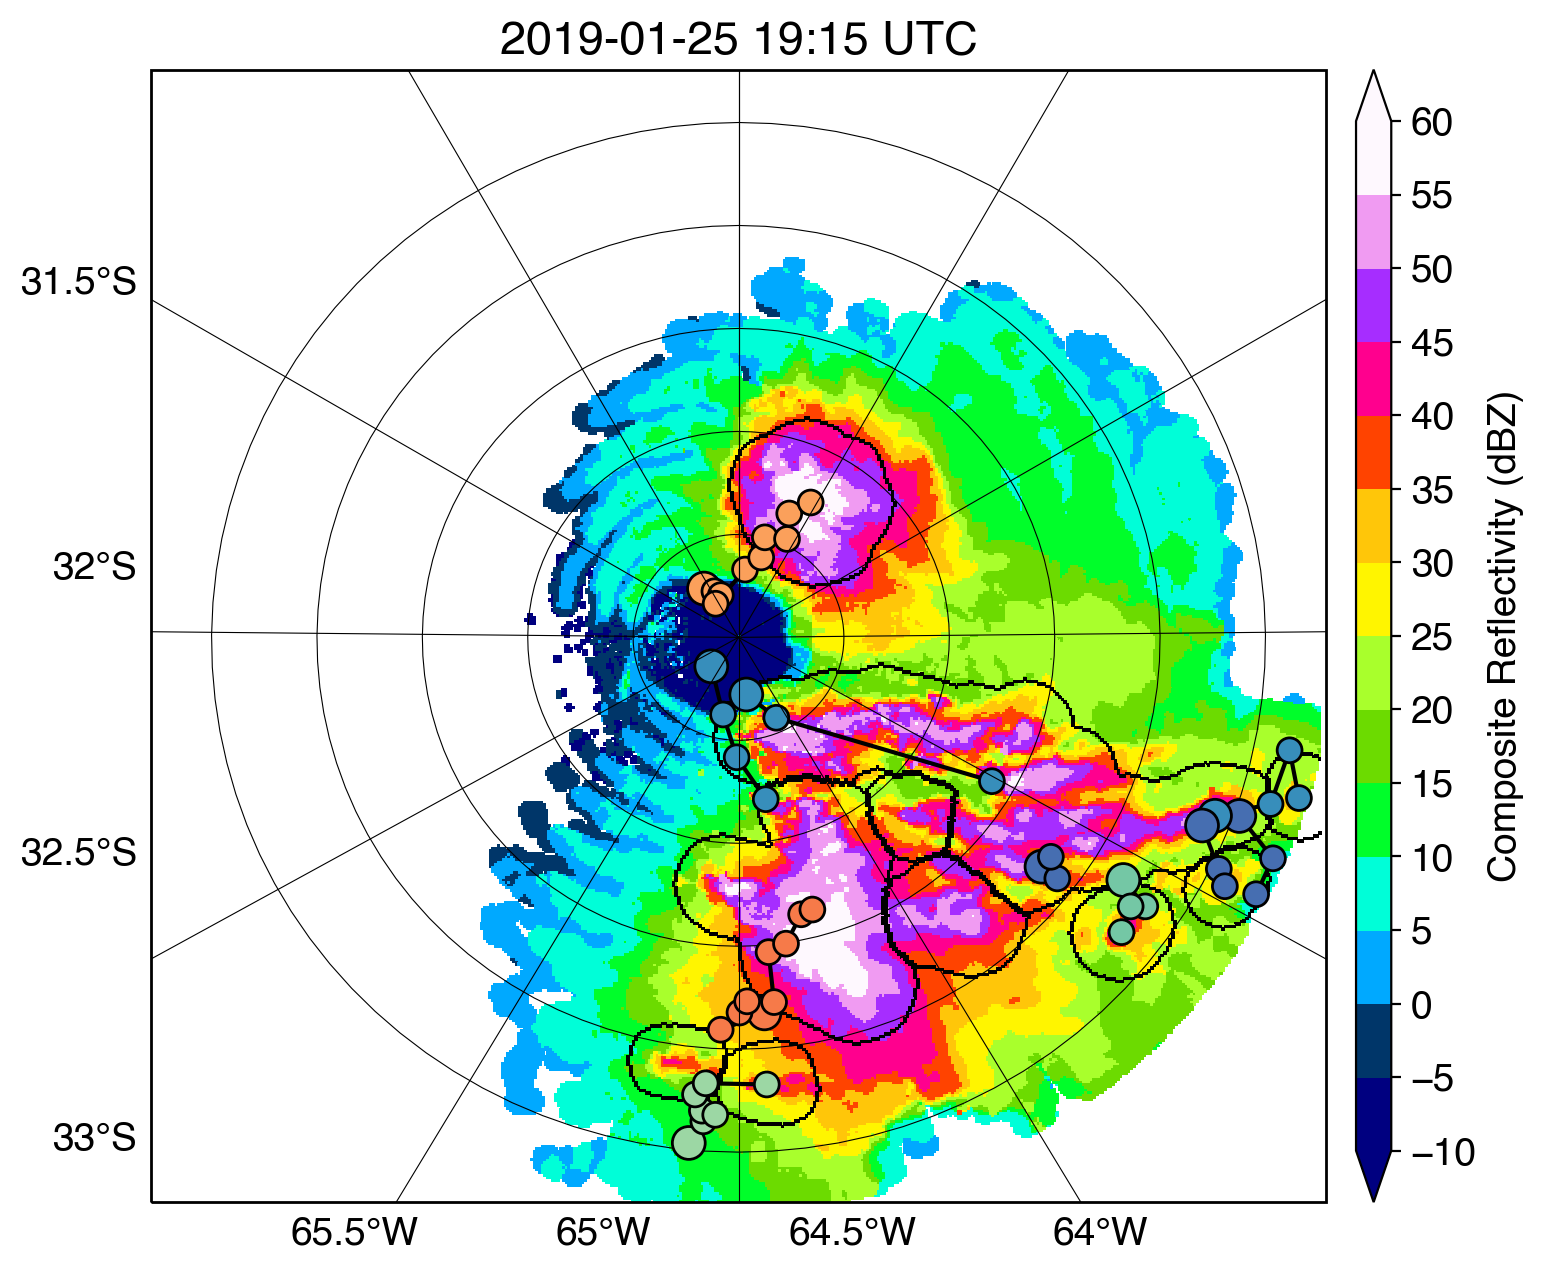

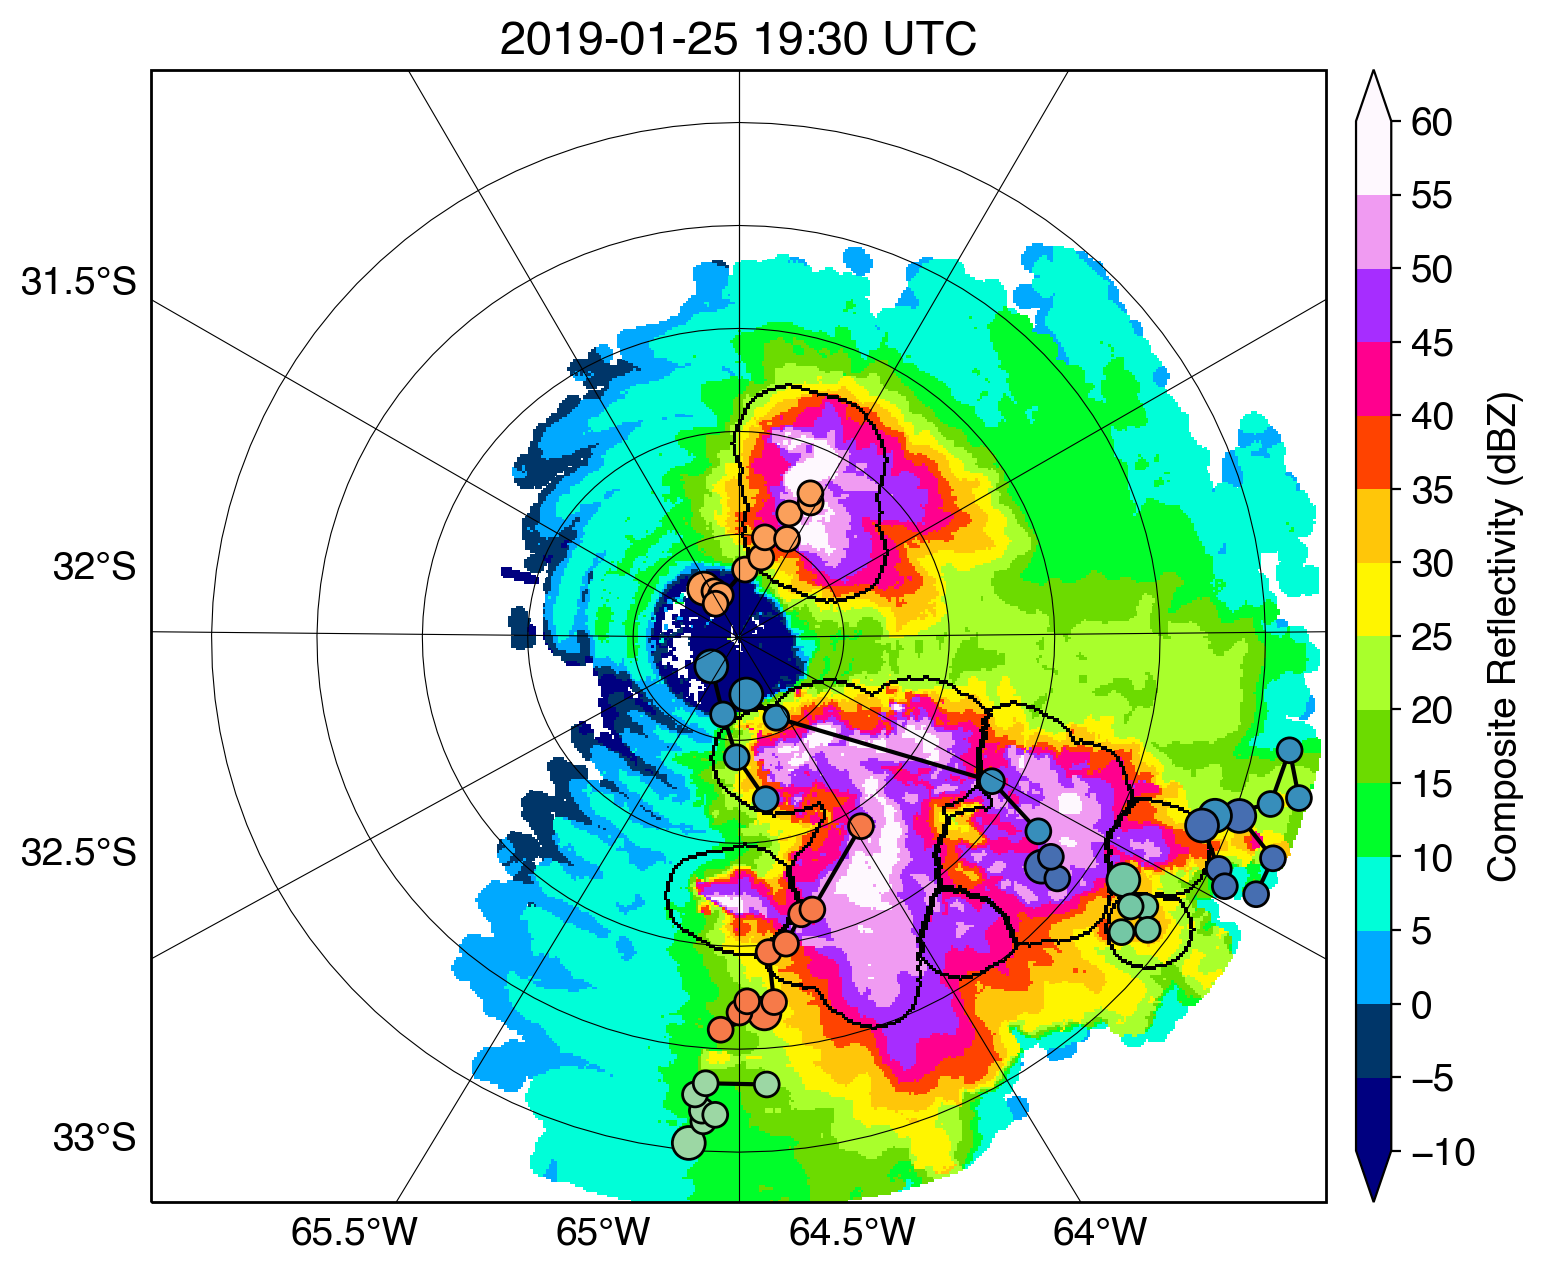

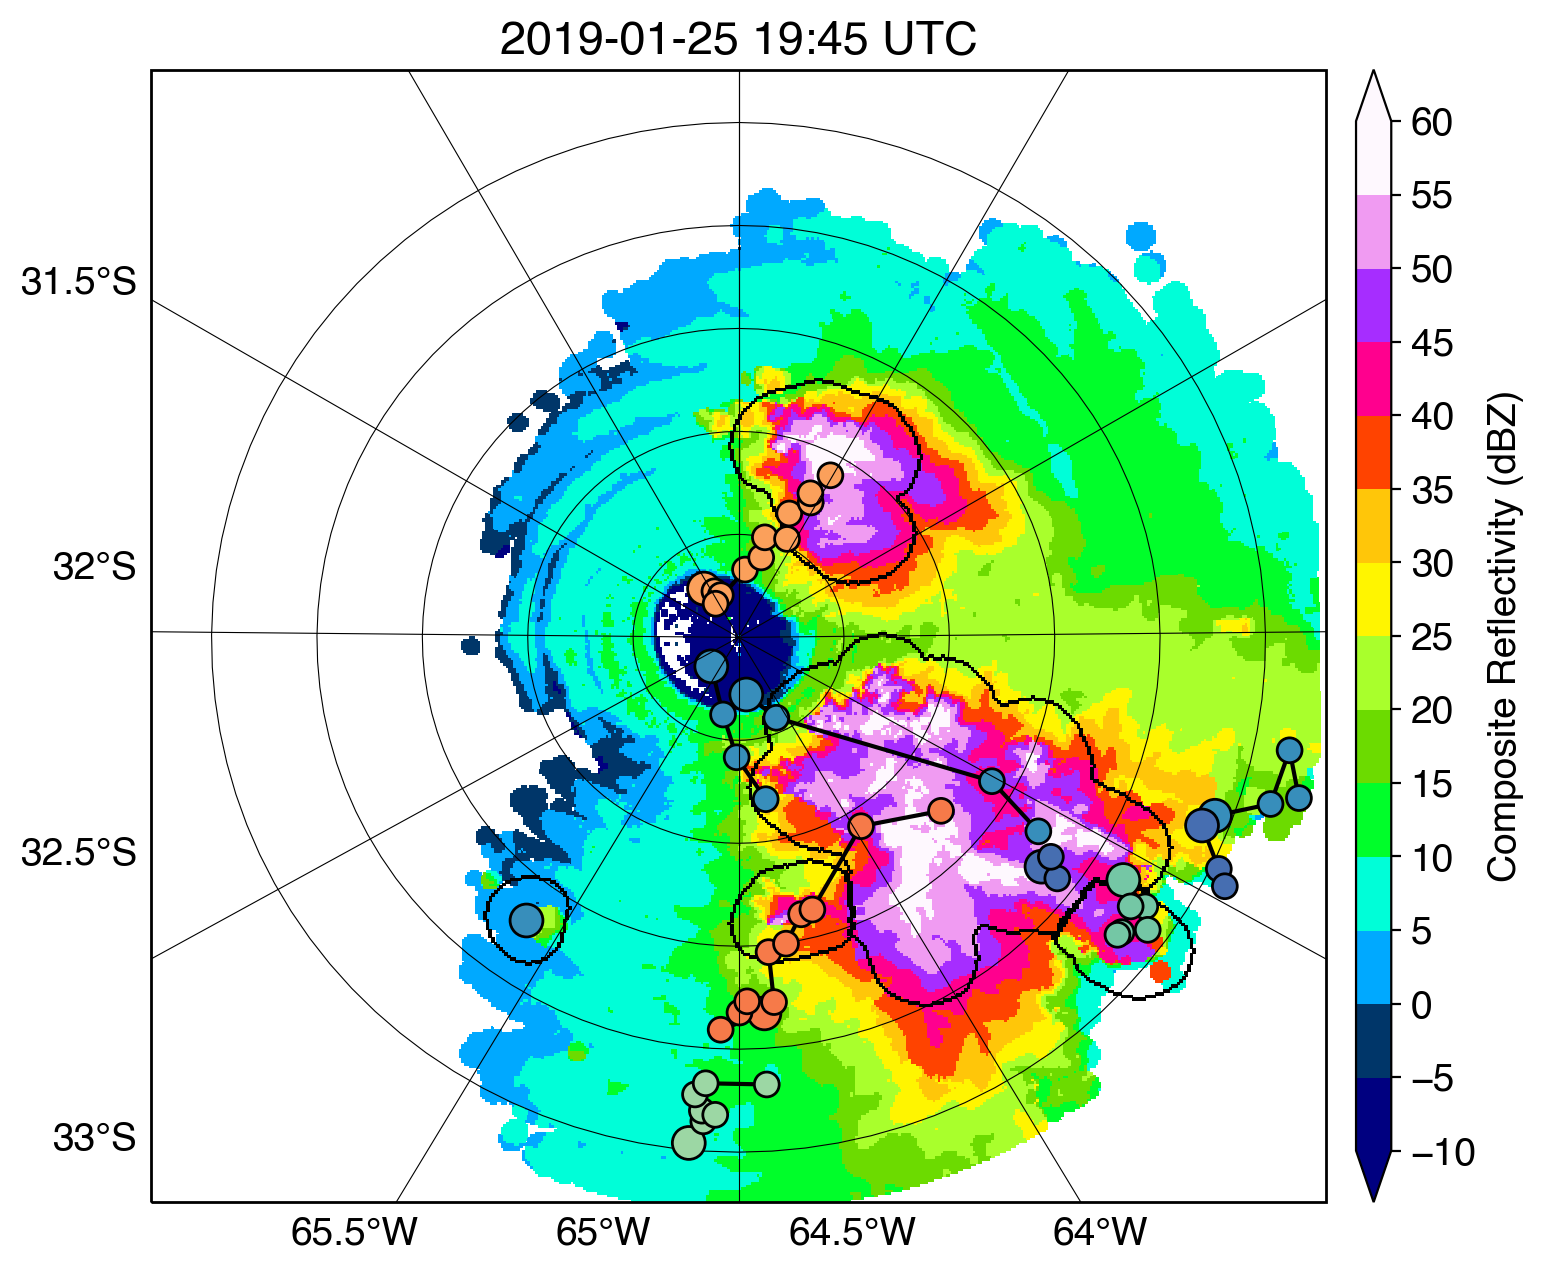

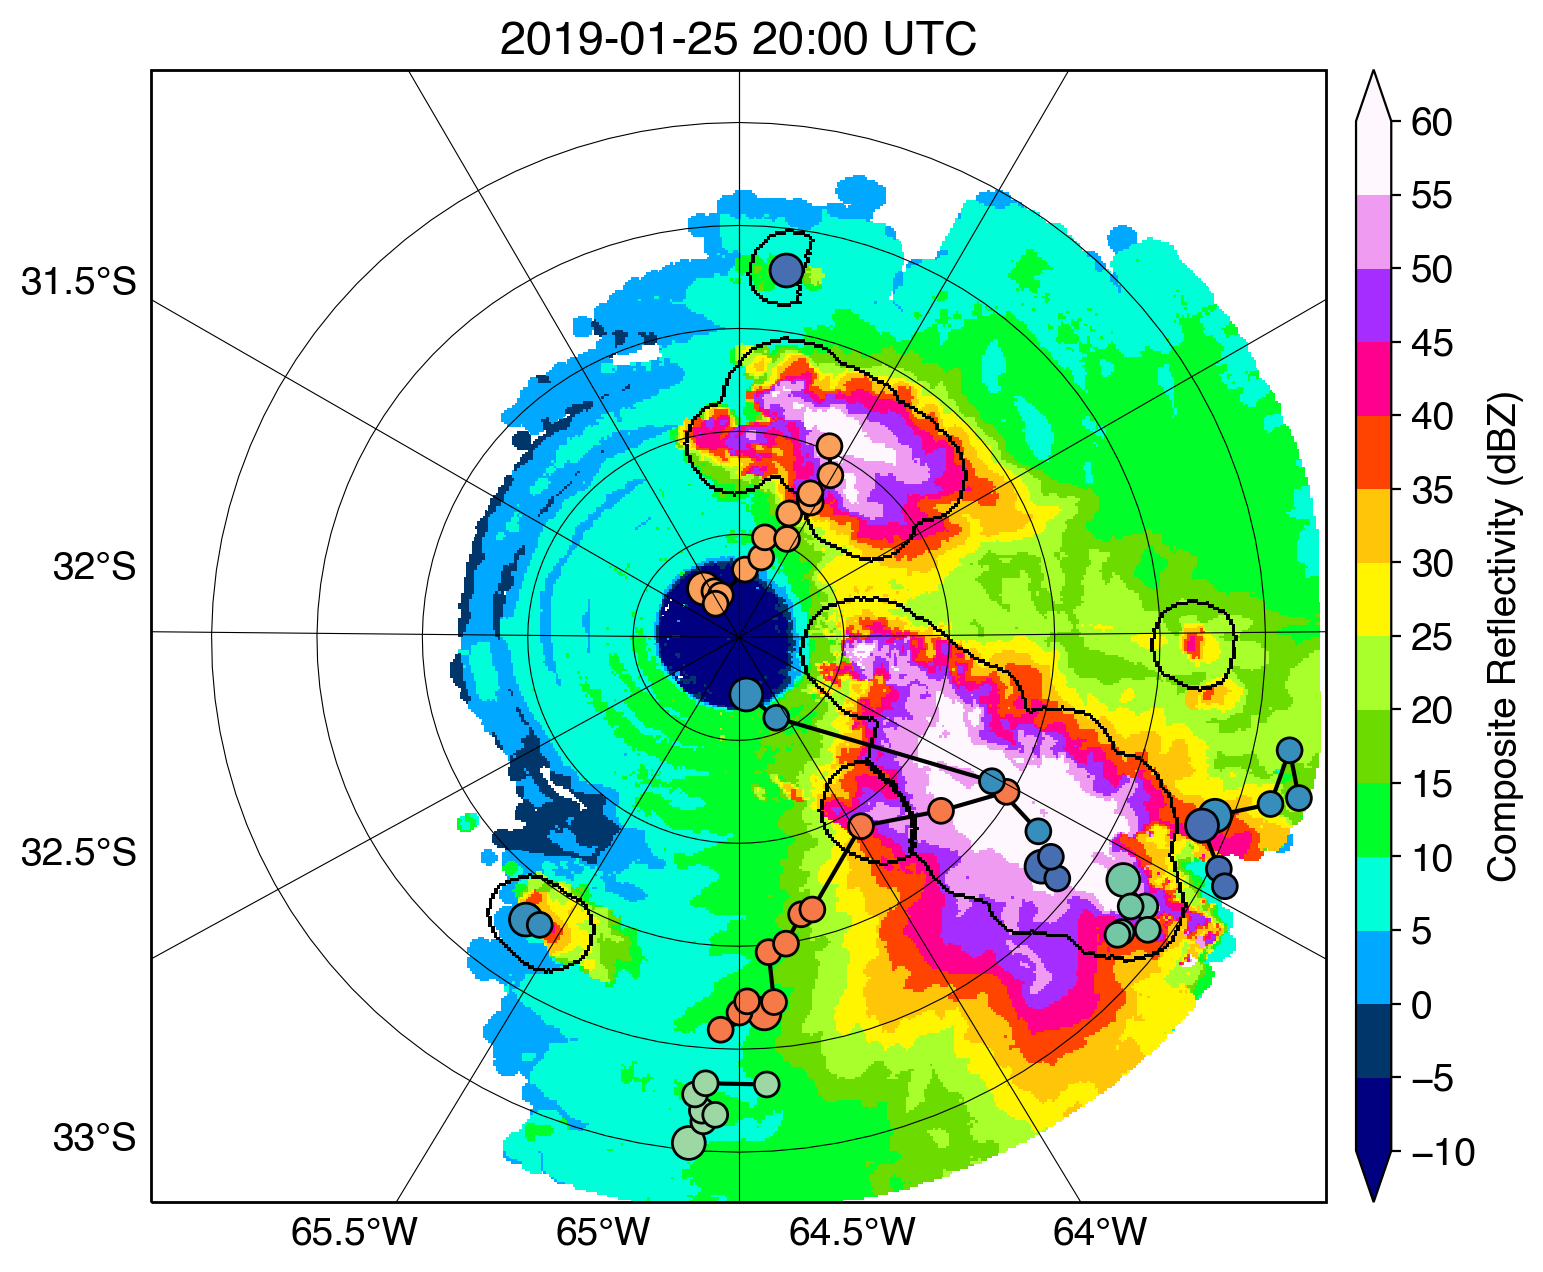

In [179]:
# Create a timedelta threshold in minutes
dt_thres = datetime.timedelta(minutes=60)

for ifile in range(len(datafiles)):
    print(datafiles[ifile])
    # Plot the current file
    # Serial
    result = work_for_time_loop(datafiles[ifile], ntracks_long, lifetime_long, cell_bt_long, cell_lon_long, cell_lat_long, dt_thres, figdir)

In [98]:
datafile = datafiles[12]
print(datafile)

# Read pixel-level data
ds = xr.open_dataset(datafile)
# Make x,y coordinates
ds.coords['lon'] = ds.lon - 100
ds.coords['lat'] = ds.lat - 100
xx = ds.lon.data
yy = ds.lat.data
longitude = ds.longitude.data
latitude = ds.latitude.data
pixel_bt = ds.time.data

# Get cell tracknumbers and cloudnumbers
tn = ds.tracknumber.squeeze()
cn = ds.cloudnumber.squeeze()

# Find cells that are not tracked (tracknumber == nan)
cn_notrack = cn.where(np.isnan(tn))

# Get cell perimeters
tn_perim = label_perimeter(tn.data)
cn_perim = label_perimeter(cn.data)
cn_notrack_perim = label_perimeter(cn_notrack.data)

# Apply tracknumber to conv_mask1
conv = ds.conv_mask.squeeze()
tnconv1 = tn.where(conv > 0).data

# Calculates cell center locations
lon_tn1, lat_tn1, xx_tn1, yy_tn1, tnconv1_uniqe = calc_cell_center(tnconv1, longitude, latitude, xx, yy)
lon_cn1, lat_cn1, xx_cn1, yy_cn1, cnnotrack_unique = calc_cell_center(cn_notrack.data, longitude, latitude, xx, yy)
    
comp_ref = ds.comp_ref.squeeze()
levels = np.arange(-10, 60.1, 5)
cbticks = np.arange(-10, 60.1, 5)
cmaps = 'gist_ncar'
timestr = ds.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
# titles = [timestr]
cblabels = 'Composite Reflectivity (dBZ)'
fignametimestr = ds.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
figname = figdir + fignametimestr + '.png'

# fig = plot_map(longitude, latitude, comp_ref, tn_perim, pixel_bt, levels, cmaps, cblabels, cbticks, timestr, 
#                ntracks_long, lifetime_long, cell_bt_long, cell_lon_long, cell_lat_long, figname)

# # plt.close(fig)
# ds.close()

/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/celltracking/20181015.0000_20190303.0000/celltracks_20190125_2000.nc


In [104]:
tnconv1_uniqe

array([6318., 6320., 6349., 6350., 6351., 6352.])

In [109]:
datetime.timedelta(minutes=60)

datetime.timedelta(seconds=3600)

In [110]:
(pixel_bt - ibt_last).astype('timedelta64[m]')

array([-30], dtype='timedelta64[m]')

In [116]:
# Create a timedelta threshold in minutes
dt_thres = datetime.timedelta(minutes=60)

for itrack in range(0, ntracks_long):
    idur = (lifetime_long.values[itrack] / time_res).astype(int)
    ibt = cell_bt_long.values[itrack,:idur]
    # Get the last time of the track
    ibt_last = np.nanmax(ibt)
    # Compute time difference between current pixel-level data time and the last time of the track
    idt = (pixel_bt - ibt_last).astype('timedelta64[m]')
    # Proceed if time difference is < threshold
    # This means for tracks that end longer than the time threshold will not be plotted
    if (idt <= dt_thres):
#         print(itrack, idt)
        # Find times in track data <= current pixel-level file time
        idx_cut = np.where(ibt <= pixel_bt)[0]
        idur_cut = len(idx_cut)
    else:
        print(itrack, idt)

1 [135]
4 [75]
5 [90]


In [101]:
cell_bt_long[5,0:5], pixel_bt

(<xarray.DataArray 'basetime' (times: 5)>
 array(['2019-01-25T18:00:00.000000000', '2019-01-25T18:15:00.000000000',
        '2019-01-25T18:30:00.000000000', '1969-12-31T21:13:21.000000000',
        '1969-12-31T21:13:21.000000000'], dtype='datetime64[ns]')
 Coordinates:
     tracks   int32 6325
   * times    (times) int32 0 1 2 3 4
 Attributes:
     long_name:      Epoch time of each cell in a track
     standard_name:  time,
 array(['2019-01-25T20:00:00.000000000'], dtype='datetime64[ns]'))

In [ ]:
cmaps = 'gist_ncar'
levels = np.arange(-10, 60.1, 5)
cbticks = np.arange(-10, 60.1, 5)
xx = longitude
yy = latitude
timestr = ds.time.squeeze().dt.strftime("%Y-%m-%d %H:%M UTC").data
titles = [timestr]
cblabels = 'Composite Reflectivity (dBZ)'
fignametimestr = ds.time.squeeze().dt.strftime("%Y%m%d_%H%M").data.item()
figname = figdir + fignametimestr + '.png'



mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Helvetica'

size_centroid = 60
radii = np.arange(20,101,20)  # radii for the range rings [km]
azimuths = np.arange(0,361,30)  # azimuth angles for HSRHI scans [degree]
radar_lon, radar_lat = -64.7284, -32.1264  # CSAPR radar location
    
topo_levs = [500,1000,1500,2000,2500]
cmap_topo = 'Reds'

radii = np.arange(20,101,20)  # radii for the range rings [km]
azimuths = np.arange(0,361,30)  # azimuth angles for HSRHI scans [degree]
radar_lon, radar_lat = -64.7284, -32.1264  # CSAPR radar location

map_extend = [np.min(xx), np.max(xx), np.min(yy), np.max(yy)]
# map_extend = [minlon, maxlon, minlat, maxlat]
lonvals = mpl.ticker.FixedLocator(np.arange(-66,-63,0.5))
latvals = mpl.ticker.FixedLocator(np.arange(-34,-30,0.5))
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=[8,7.5], dpi=100)
gs = gridspec.GridSpec(1,2, height_ratios=[1], width_ratios=[1,0.03])
gs.update(wspace=0.05, hspace=0.05)

# ax1 = plt.subplot(111, projection=proj)
ax1 = plt.subplot(gs[0], projection=proj)
ax1.set_extent(map_extend, crs=proj)
ax1.set_aspect('auto', adjustable=None)
gl = ax1.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0, zorder=5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1, transform=proj)

# Plot reflectivity
cmap = plt.get_cmap(cmaps)
norm_ref = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
cf1 = ax1.pcolormesh(xx, yy, comp_ref, norm=norm_ref, cmap=cmap, transform=proj, zorder=2)
# Overplot cell tracknumber perimeters
Tn = np.ma.masked_where(tn_perim == 0, tn_perim)
Tn[Tn > 0] = 10
tn1 = ax1.pcolormesh(xx, yy, Tn, cmap='gray', transform=proj, zorder=3)

# Plot track centroids and paths
marker_style = dict(edgecolor='k', linestyle='-', marker='o')
for itrack in range(0, ntracks_long):
# for itrack in range(9, 10):
    idur = (lifetime_long.values[itrack] / time_res).astype(int)
    ibt = cell_bt_long.values[itrack,:idur]
    # Get the last time of the track
    ibt_last = np.nanmax(ibt)
    # Compute time difference between current pixel-level data time and the last time of the track
    idt = (pixel_bt - ibt_last).astype('timedelta64[m]')
    # Proceed if time difference is <= threshold
    # This means for tracks that end longer than the time threshold will not be plotted
    if (idt <= dt_thres):
        # Find times in track data <= current pixel-level file time
        idx_cut = np.where(ibt <= pixel_bt)[0]
        idur_cut = len(idx_cut)
        if (idur_cut > 0):
            color_vals = np.repeat(lifetime_long.values[itrack], idur_cut)
            size_vals = np.repeat(size_centroid, idur_cut)
            cc = ax1.plot(cell_lon_long.values[itrack,idx_cut], cell_lat_long.values[itrack,idx_cut], ls='-', color='k', transform=proj, zorder=3)
            cl = ax1.scatter(cell_lon_long.values[itrack,idx_cut], cell_lat_long.values[itrack,idx_cut], s=size_vals, c=color_vals, 
                             vmin=0.5, vmax=5, cmap='Spectral_r', transform=proj, zorder=4, **marker_style)
        
# Plot range circles around radar
for ii in range(0, len(radii)):
    rr = ax1.tissot(rad_km=radii[ii], lons=radar_lon, lats=radar_lat, n_samples=100, facecolor='None', edgecolor='k', lw=0.4, zorder=3)
# Plot azimuth lines
for ii in range(0, len(azimuths)):
    lon2, lat2 = calc_latlon(radar_lon, radar_lat, 200, azimuths[ii])
    ax1.plot([radar_lon,lon2], [radar_lat,lat2], color='k', lw=0.4, transform=ccrs.Geodetic(), zorder=5)
# Reflectivity colorbar
cax1 = plt.subplot(gs[1])
cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels, ticks=cbticks, extend='both')
ax1.set_title(titles[0])

fig.savefig(figname, dpi=300, bbox_inches='tight')

# # Thread-safe figure output
# canvas = FigureCanvas(fig)
# canvas.print_png(figname)
# fig.savefig(figname)

In [ ]:
type(lifetime.values[itrack])

In [ ]:
np.repeat(lifetime.values[itrack], lifetime.values[itrack]/time_res)